In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from RunningEnv import RunningEnv
from RunningEnv import EnvWrapper
from RunningEnv import EwmaBiasState
from TransitionBatch import TransitionBatch
import torch as th
import numbers

In [2]:
pref_pace = 181
target_pace = pref_pace*1.1
gamma = 0.99

In [3]:
#Make environment
env = EnvWrapper(pref_pace, target_pace)

In [4]:
class HeuristicAgent:
    def __init__(self):
        self.initial_wait = 20
        self.initial_completed = False

    def select_action(self, state):
        avg_pace = state[0]
        action = 0

        # Initial waiting time
        if not(self.initial_completed):
            self.initial_wait = self.initial_wait - 1
            if self.initial_wait == 0:
                self.initial_completed = True

        if abs(avg_pace) > 27e-3:
            action = 4

        elif abs(avg_pace) > 22e-3:
            action = 3

        elif abs(avg_pace) > 15e-3:
            action = 2

        elif abs(avg_pace) > 11e-3:
            action = 1

        return action

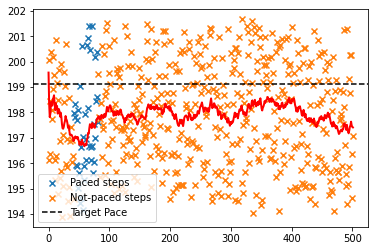

6235.0


In [11]:
heuristic_agent = HeuristicAgent()

state = env.reset()
done = 0

while not done:
    action = heuristic_agent.select_action(state)
    new_state, reward, done = env.step(action)
    # if action != 0:
    #     print(action, state, new_state, reward)
    state = new_state

x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.scatter(x[np.array(env.env_pacing)==1], np.array(env.pace)[np.array(env.env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env.env_pacing)==0], np.array(env.pace)[np.array(env.env_pacing)==0], marker="x", label='Not-paced steps')

plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.legend()
plt.show()

print(np.sum(env.rewards))

In [6]:
rewards = []

for _ in range(50):
    # for _ in range(self.plot_frequency):
    state = env.reset()
    done = False
    score = 0
    while not done:
        action = heuristic_agent.select_action(state)
        # action = 1
        new_state, reward, done = env.step(action)
        score += reward
        state = new_state
    rewards.append(score)

print(np.mean(rewards))

5960.7


In [7]:
state_shape = (1,)
def transition_format():
    """ Returns the format of transtions: a dictionary of (shape, dtype) entries for each key. """
    return {'actions': ((1,), th.long),
            'states': (state_shape, th.float32),
            'next_states': (state_shape, th.float32),
            'rewards': ((1,), th.float32),
            'dones': ((1,), th.bool),
            'returns': ((1,), th.float32)}

In [8]:
def _wrap_transition(s, a, r, ns, d):
    """ Takes a transition and returns a corresponding dictionary. """
    trans = {}
    form = transition_format()
    for key, val in [('states', s), ('actions', a), ('rewards', r), ('next_states', ns), ('dones', d)]:
        if not isinstance(val, th.Tensor):
            if isinstance(val, numbers.Number) or isinstance(val, bool): val = [val]
            val = th.tensor(val, dtype=form[key][1])
        if len(val.shape) < len(form[key][0]) + 1: val = val.unsqueeze(dim=0)
        trans[key] = val
    return trans

In [9]:
my_transition_buffer = TransitionBatch(4500, transition_format())
time, episode_start, episode_lengths, episode_rewards = 0, 0, [], []
max_steps = 1000

In [10]:
for t in range(max_steps):
    # One step in the envionment with heuristic
    a = heuristic_agent.select_action(state)
    r, ns, d = env.step(a)
    terminal = d
    my_transition_buffer.add(_wrap_transition(state, a, r, ns, terminal))

    # Compute discounted returns if episode has ended or max_steps has been reached
    if d or t == (max_steps - 1):
        my_transition_buffer['returns'][t] = my_transition_buffer['rewards'][t]
        for i in range(t - 1, episode_start - 1, -1):
            my_transition_buffer['returns'][i] = my_transition_buffer['rewards'][i] \
                                                 + gamma * my_transition_buffer['returns'][i + 1]
        episode_start = t + 1
    # Remember statistics and advance (potentially initializing a new episode)
    if d:
        env.reset()
    time += 1


In [11]:
sample = my_transition_buffer.sample()

In [4]:
def default_params():
    """ These are the default parameters used int eh framework. """
    return {  # Debugging outputs and plotting during training
        'plot_frequency': 10,  # plots a debug message avery n steps
        'plot_train_samples': True,  # whether the x-axis is env.steps (True) or episodes (False)
        'print_when_plot': True,  # prints debug message if True
        'print_dots': False,  # prints dots for every gradient update
        # Environment parameters
        'env': 'CartPole-v0',  # the environment the agent is learning in
        'run_steps': 0,  # samples whole episodes if run_steps <= 0
        'max_episode_length': 500,  # maximum number of steps per episode
        # Runner parameters
        'max_episodes': int(1E6),  # experiment stops after this many episodes
        'max_batch_episodes': int(1E6),  # experiment stops after this many batch
        'max_steps': int(1E9),  # experiment stops after this many steps
        'multi_runner': False,  # uses multiple runners if True
        'parallel_environments': 4,  # number of parallel runners  (only if multi_runner==True)
        # Exploration parameters
        'epsilon_anneal_time': int(5E3),  # exploration anneals epsilon over these many steps
        'epsilon_finish': 0.1,  # annealing stops at (and keeps) this epsilon
        'epsilon_start': 1,  # annealing starts at this epsilon
        # Optimization parameters
        'lr': 1E-4,  # 5E-4,                       # learning rate of optimizer
        'gamma': 0.99,  # discount factor gamma
        'batch_size': 2048,  # number of transitions in a mini-batch
        'grad_norm_clip': 1,  # gradent clipping if grad norm is larger than this
        # DQN parameters
        'replay_buffer_size': int(1E5),  # the number of transitions in the replay buffer
        'use_last_episode': True,  # whether the last episode is always sampled from the buffer
        'target_model': True,  # whether a target model is used in DQN
        'target_update': 'soft',  # 'soft' target update or hard update by regular 'copy'
        'target_update_interval': 10,  # interval for the 'copy' target update
        'soft_target_update_param': 0.01,  # update parameter for the 'soft' target update
        'double_q': True,  # whether DQN uses double Q-learning
        'grad_repeats': 1,  # how many gradient updates / runner call
        # Image input parameters
        'pixel_observations': False,  # use pixel observations (we will not use this feature here)
        'pixel_resolution': (78, 78),  # scale image to this resoluton
        'pixel_grayscale': True,  # convert image into grayscale
        'pixel_add_last_obs': True,  # stacks 2 observations
        'pixel_last_obs_delay': 3,  # delay between the two stacked observations

        # Runners env
        'pref_pace': 181,  # Athlete's preferred pace
        'target_pace': pref_pace * 1.1,  # Athlete's target pace
        'states_shape': (1,),  # Amount of states
        'num_actions': 5,  # Possible actions
    }

In [5]:
def test_in_environment(experiment, env):
    state = env.reset()
    try_scores = []

    for _ in range(50):
        env.reset()
        state = env.step(0)[0]
        done = False
        score = 0
        while not done:
            action = experiment.controller.choose(state, increase_counter=False).detach().item()
            new_state, reward, done = env.step(action)
            score += reward
            state = new_state
        try_scores.append(score)
    print(np.array(try_scores).mean())

    # Print one episode

    env.reset()
    state = env.step(0)[0]
    done = False

    while not done:
        action = experiment.controller.choose(state, increase_counter=False).detach().item()
        new_state, reward, done = env.step(action)

        # if action == 0:
        #     print(env.steps, action)
        # if reward < 0:
        #     print(action, state, new_state, reward)
        # if (action != 5):
        # #     # print(action, (state+1)*pref_pace, (new_state+1)*pref_pace, reward)
        #     print(action, state, new_state, reward)
        state = new_state

    x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
    plt.figure()
    plt.scatter(x[np.array(env.env_pacing) == 1], np.array(env.pace)[np.array(env.env_pacing) == 1], marker="x",
                label='Paced steps')
    plt.scatter(x[np.array(env.env_pacing) == 0], np.array(env.pace)[np.array(env.env_pacing) == 0], marker="x",
                label='Not-paced steps')

    # plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
    # plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

    # plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
    plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

    plt.plot(x, env.state_traj, 'r-', linewidth=2)
    plt.legend()
    plt.show()

    print(np.sum(env.rewards))

In [6]:
data_model = []
heuristic = []
semi_online = []

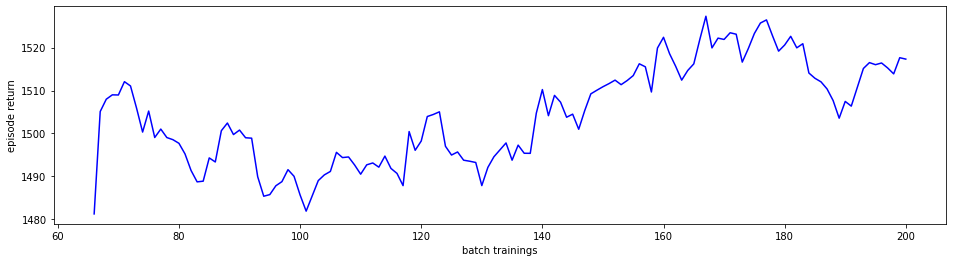

Batch 199 1540 +- 76.9


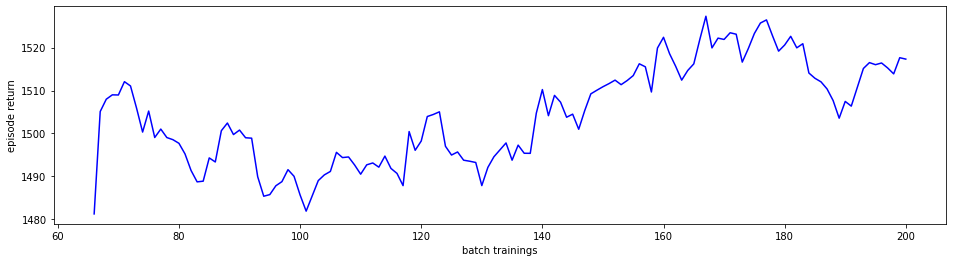

In [7]:
from Model.Learners import PPOLearner
from Model.Experiments import ActorCriticExperimentHeuristic

params = default_params()
params['offpolicy_iterations'] = 128
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(200)
params['batch_size'] = 500
params['epsilon_start'] = 0.1

env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperimentHeuristic(params, model, learner=PPOLearner(model, params=params))
# experiment = ActorCriticExperimentRunning(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
experiment.run()
# except KeyboardInterrupt:
#     experiment.close()
# experiment.plot_training()
heuristic = experiment.episode_returns

1510.3799724156158


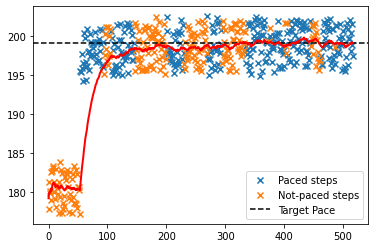

-4521.872490372214


In [8]:
test_in_environment(experiment, env)

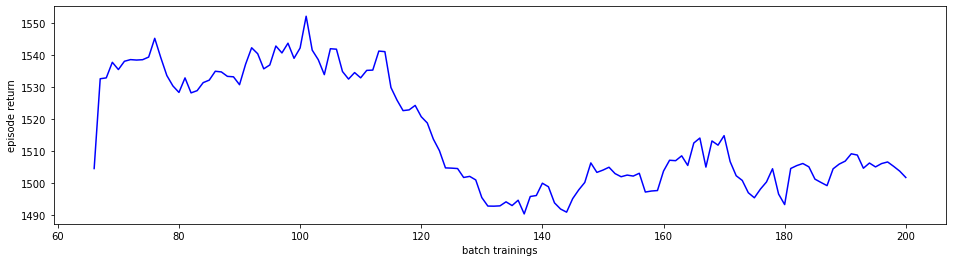

Batch 199 1522 +- 124


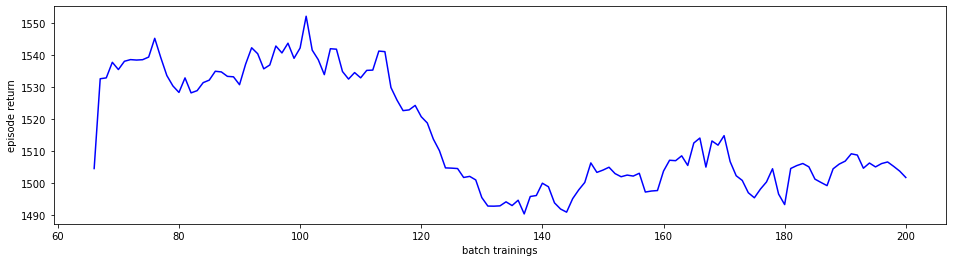

In [9]:
from Model.Experiments import ActorCriticExperimentRunning

params = default_params()
params['offpolicy_iterations'] = 128
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(200)
params['batch_size'] = 500
params['epsilon_start'] = 0.1

env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperimentRunning(params, model, learner=PPOLearner(model, params=params))
# experiment = ActorCriticExperimentRunning(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
experiment.run()
# except KeyboardInterrupt:
#     experiment.close()
# experiment.plot_training()
data_model = experiment.episode_returns

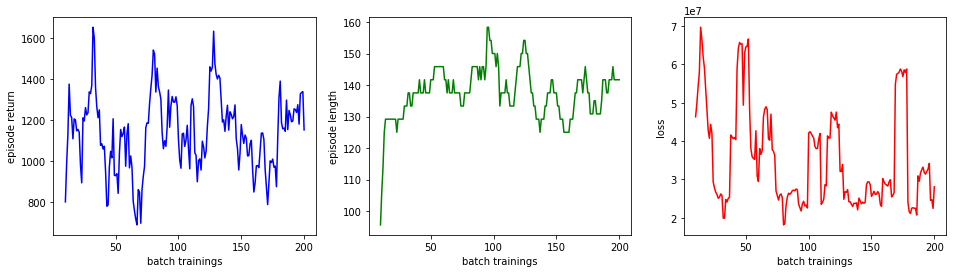

In [13]:
from Model.Experiments import ActorCriticExperiment

params = default_params()
params['offpolicy_iterations'] = 128
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(200)
params['batch_size'] = 500
params['epsilon_start'] = 0.1

env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=PPOLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

semi_online = experiment.episode_returns

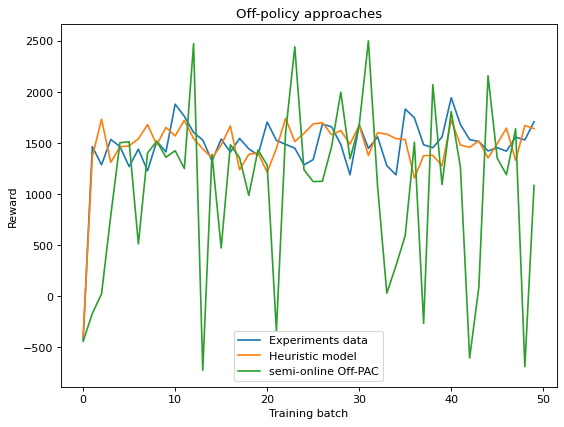

In [23]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(data_model[:50], label="Experiments data")
plt.plot(heuristic[:50], label="Heuristic model")
plt.plot(semi_online[:50], label="semi-online Off-PAC")
plt.title("Off-policy approaches")
plt.ylabel(r'Reward')
plt.xlabel(r'Training batch')
plt.legend()
# plt.savefig('off_policy_approaches.pdf')